# 簡単なモンテカルロ・シミュレーション
多数の粒子の相互作用によって生じている現象を確率の考え方を使って記述するというのが統計力学です。統計力学の問題が解析的に解けない場合には数値シミュレーションをする必要がありますが、モンテカルロ法はその代表例の一つです。古典系にも量子系（量子系の場合は鈴木トロッター分解などの手続きが必要）にも扱えますが、今回は古典系、その代表例のイジング模型でのモンテカルロ・シミュレーションを扱ってみたいと思います。

## 統計力学のおさらい
モンテカルロ法で使う統計力学の考え方を、ざっとおさらいしておきましょう。

生じる現象の確率分布が$p$で与えられるとします。発生しうる状態にそれぞれi=1,2,3…とラベルを振り、
それぞれの状態が生じる確率を$p_i$と書くと、期待値（平均値）は$$<f>_p=\sum_i^\Omega f_i p_i$$で与えられます。

物理における基本的な確率分布はボルツマン分布で表されます。ボルツマン分布は
$$
p_i = e^{-\beta E_i}/Z(\beta)
$$
と書けます。

ここで、$E_i$は各状態でのエネルギーを、$\beta=\frac{1}{k_B T}$ (Tは温度、$k_B$はボルツマン定数)であり、
$Z(\beta)$は分配関数と呼ばれる、確率分布を求める時の分母、つまりあらゆる場合を数え上げた結果に相当します。この定義から
$$
Z(\beta)=\sum_i e^{-\beta E_i}
$$

となります。

ここまでの話を組み合わせると、物理量Aの期待値が 
$$<A>=\frac{1}{Z(\beta)}\sum_i A_i e^{-\beta E_i}$$
で与えられます。

ある温度Tが与えられ、すべての取りうる状態とそのエネルギーが分かれば、原理的には上記の期待値を計算することができます。が、このすべての取りうる値を数え上げるというのが、困難な場合が多々あります。対象とする系が沢山の原子を含む場合などを考えればイメージできるでしょう。

## モンテカルロ法

そのようなときに、有用となる計算テクニックの一つがモンテカルロ法です。モンテカルロ法は、乱数を利用した計算アルゴリズムの総称です。モンテカルロ法では、「すべての状態を数え上げる」かわりに、乱数を使って適当な状態のサンプルを発生させ、それを用いて期待値を計算するということを行います。ただ、物理量の期待値をまともに計算するためには、無闇矢鱈に乱数でサンプルを発生させるのではなく、熱平衡状態での分布を再現するような形でサンプルを発生させる必要があります。このために用いられる概念が確率過程、特に「マルコフ過程」です。

確率過程は、なんらかの試行が繰り返し行われ、そのたびに確率変数が変化しうるような過程のことを指します。マルコフ過程は、ある試行時にある現象が起きる確率が、直前の試行で生じた事象にだけ依存する性質をもつ確率過程です。特に、マルコフ過程のうち、取り得る状態が離散的なものをマルコフ連鎖と呼びます。

マルコフ連鎖によるサンプリングを用いて熱平衡状態を計算するためには、2つの条件が必要となります。それは、エルゴード性と詳細釣り合いの条件と呼ばれるものです。

エルゴード性はマルコフ連鎖内のどの状態からスタートしても、すべての状態に移りうるという条件です。

詳細釣り合いの条件というのは状態iから状態jへの遷移確率を$w(i\rightarrow j)$, 状態iの確率分布を$P(i)$としたときに
$P(i)w(i\rightarrow j)=P(j)w(j\rightarrow i)$
であるという条件式です。

この2つの条件が成り立つ場合、元の確率分布を保ったままランダムなサンプリングを行うことが可能になります。

この2つの条件が成り立つ具体的なサンプリング方法にはいくつかのものがあります。代表的なものの名称を挙げると、熱浴法、ギブスサンプラー、メトロポリス法などです。ここでは特にメトロポリス法を取り上げたいと思います。

メトロポリス法のアルゴリズムは一般的には以下のようなステップから成ります。（対象とする系によって上の条件を満たす範囲での少々のアレンジがあります。）

- ステップ０：初期化　（適当な状態を生成する）

- ステップ１：現在の状態($X_i$)から変化させた候補($X_{i+1}$)を生成する
- ステップ２：現在の状態の確率分布$P_i$と候補の状態の確率分布$P_{i+1}$から遷移確率$P_{i+1}/P_i$を決める。
- ステップ３：区間\[0,1\]で乱数rを発生させ、もし$r < P_{i+1}/P_{i}$ならば、状態を$X_{i+1}$に更新する。そうでなければ状態は$X_i$のままに保つ
- ステップ４：ステップ１に戻り、1~3を繰り返す

大まかな説明はこのようなものなのですが、具体的に扱ってみないとイメージが湧かないと思います。今回は、こうした統計力学的シミュレーションの代表例であるイジング模型を取り上げたいと思います。


## イジング模型
イジング模型は、オリジナルには磁性体の振る舞いをモデル化するために考えられた模型です。ですが、対象は磁性体に限らず、多数の対象の間に相互作用があるときにどのような現象が生じるかを解明するために広く用いられています。合金の研究などにも使われていますし、意外なところでは画像処理などにも応用されています。

イジング模型では一般的にエネルギーは

$$
E=-J \sum_{<i,j>} \sigma_i \sigma_j - \mu_B \sum_i \sigma_i H
$$

のように定義されます。$\sigma_i, \sigma_j$はそれぞれ、1または-1の値を取ります。これはそれぞれ上向きスピン、下向きスピンに対応しています。
第一項は隣接するスピンの間の相互作用を表しています$<i,j>$は隣り合うスピンの組を指定しています。第二項は磁場がある場合に、磁場とスピンの間に生じる相互作用を表しています。

２次元正方格子のイジング模型のイメージを図で表すと以下のようになります。

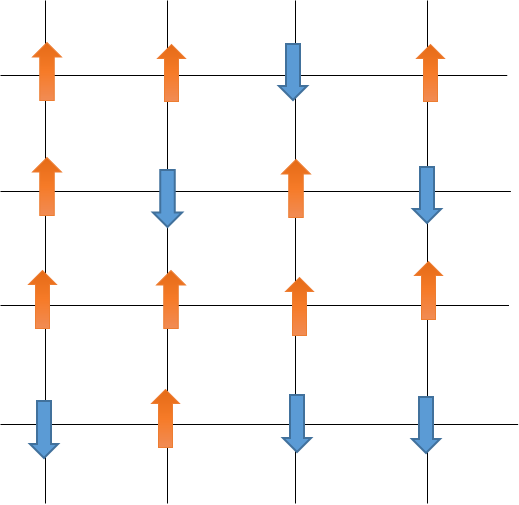

In [1]:
from IPython.display import Image
Image("./img/Ising.png")

この模型が再現する典型的な現象が磁気相転移です。磁気相転移というと言葉は難しいですが、磁石になったり、磁石の性質が消えたりということです。皆さんも、小学校か中学校かで、磁石を加熱していくと磁石ではなくなるというのを実験したことがあると思います。これが「磁性状態から非磁性状態への相転移」に対応しています。

磁性状態にあるかどうかは、格子点上にあるスピン$\sigma_i$を足し上げたときの値（磁化）で判定できます。系のサイズに依らない議論をしたいので格子点あたりの磁化

$$
M/N=\sum_i \sigma_i/N
$$

を計算することが多いです。ここでNは格子点の総数を示しています。上の図の例では上向きスピンが１０個に対して、下向きスピンが6個、格子点の数は16個なので、格子点あたりの磁化は0.25ですね。

磁気相転移は２次元以上の次元を持つイジング模型で現れます。なので、今回は２次元正方格子のイジング模型について、温度が変わったときに、エネルギーや磁化がどういった振る舞いをするかのモンテカルロ・シミュレーションをしてみましょう。

## ２次元正方格子イジング模型のモンテカルロ・シミュレーション
では実際にモンテカルロ・シミュレーションのコードを書いて動かしてみましょう。今回のシミュレーションでは上記で説明したメトロポリスのアルゴリズムを使います。ただ、イジング模型に応用する際には、いくつか注意を要する点があります。

1. 境界条件をどうするか
数値シミュレーションをするにあたっては、無限のサイズの系を扱うわけにはいかないので、上の図のような4x4等の計算の対象とする系のサイズを決める必要があります。そうした場合、一番端の格子点上のスピンが持つ相互作用をどのように扱うかという問題が出てきます。（$-J\sigma_N \sigma_{N+1}$ の$\sigma_{N+1}$をどうするかという問題）
巨視的な現象が知りたく、端で生じる効果を取り入れたくない場合には周期的境界条件、すなわち$\sigma_{N+1}=\sigma_1$のように扱うことが一般的です
（Pythonプログラム上では、配列は0から始まるので$\sigma_0$のような添え字が0の要素で置き換えます。以下のコードでもそうしているので要注意）

1. 候補の状態の作り方や遷移確率などの計算について
統計力学における確率分布は
$P_i = e^{-\beta E_i}/Z(\beta)$
ですから、候補状態の確率分布は
$$
P_{i+1} = e^{-\beta E_{i+1}/Z(\beta)}
$$
よって、遷移確率は
$$\frac{P_{i+1}}{P_i}=e^{-\beta(E_{i+1}-E_i})$$
となります。元々の状態のエネルギーと候補の状態のエネルギーの差　$E_{i+1}-E_i$が遷移確率を決めるファクターです。

では候補の状態と言うものをどうやって生成するかというと、イジング模型のモンテカルロ法の場合に最も一般的な方法は、ランダムに何処か一つの格子点上のスピンを反対向きにするという方法です。
このような方法で生成された候補の場合、全エネルギーよりも$E_{i+1}-E_i$の差のほうが容易に計算できます。二次元のイジング模型をx方向、ｙ方向の添字を使って書き下すと以下のようになります。

$$E=-J \sum_{<i,j>}( \sigma_{ij} \sigma_{i+1 j} +\sigma_{ij} \sigma_{i j+1}) - \mu_B \sum_{ij} \sigma_{ij} H$$

ここで、ある添字$\alpha, \beta$のスピンが反転されたとすると、その状態と元の状態とのエネルギー差は

$$\delta E = 2J\sigma_{\alpha \beta} (\sigma_{\alpha+1 \beta}+\sigma_{\alpha\beta+1}) +2\mu_B \sigma_{\alpha\beta} H$$

であることが確認できるでしょう。

これらの候補の生成と、エネルギー差を使ったメトロポリスのアルゴリズムは以下のように書けます

- ステップ０：初期化　（適当なスピン配置を生成しエネルギーを計算する）
- ステップ１：現在の状態から、ランダムに格子点を一つ選び、スピンを反転させた候補を生成する
- ステップ２：現在の状態と候補の状態のエネルギー差を計算する。
- ステップ３：エネルギー差が負であれば、状態を更新し、エネルギー差を使ってエネルギーも更新する。エネルギー差が正の場合には区間\[0,1\]で乱数rを発生させ、もし$r < e^{-\beta(E_{i+1}-E_i})$ならば、状態とエネルギーを更新する。そうでなければ状態もエネルギーも元のままに保つ。
- ステップ４：ステップ１に戻り、1~3を繰り返す

以下のコードは上記のアルゴリズムをpythonで実装したものです。
メトロポリス法を用いてモンテカルロ法のサンプリングを行い、全エネルギーと磁化を求めてそれをプロットすることを行っています。
以下の例はサンプルコードなので、ステップ数などを小さくしています（steps =4000 ）。なので得られる値は物理的に正確でないです。

calculation at KBT:0.001
calculation at KBT:0.2509583333333333
calculation at KBT:0.5009166666666666
calculation at KBT:0.750875
calculation at KBT:1.0008333333333332
calculation at KBT:1.2507916666666665
calculation at KBT:1.5007499999999998
calculation at KBT:1.750708333333333
calculation at KBT:2.0006666666666666
calculation at KBT:2.250625
calculation at KBT:2.500583333333333
calculation at KBT:2.7505416666666664
calculation at KBT:3.0004999999999997
calculation at KBT:3.250458333333333
calculation at KBT:3.5004166666666663
calculation at KBT:3.7503749999999996
calculation at KBT:4.000333333333333
calculation at KBT:4.250291666666667
calculation at KBT:4.50025
calculation at KBT:4.750208333333333
calculation at KBT:5.000166666666667
calculation at KBT:5.250125
calculation at KBT:5.500083333333333
calculation at KBT:5.750041666666666
calculation at KBT:6.0


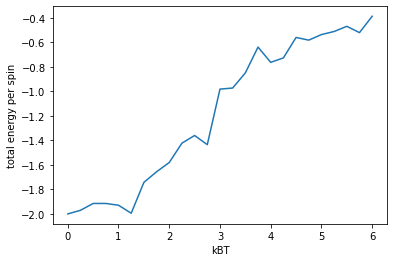

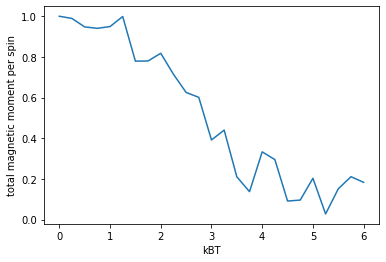

In [2]:

import random
import numpy as np
import matplotlib.pyplot as plt

#calculation of the total energy for initial state
#spin[0~nx-1,0~ny-1]

def Einit(spin, nx, ny):
    ene=0
    for i in range(nx):
        for j in range(ny):
            l=i
            m=j
            ll=i+1
            if ll == nx:
                ll=0
            mm=j+1
            if mm == ny:
                mm=0
            ene+=spin[l, m]*spin[ll, m] +spin[l, m]*spin[l, mm] 
    return ene

def initialSpin(nx,ny):
    spin=np.ones((nx,ny),int)
    #random
    nn=int(nx*ny/2)
    for i in range(nn):
        ix=random.randrange(nx-1)
        iy=random.randrange(ny-1)
        spin[ix,iy]=-spin[ix,iy]
    
    return spin

nx=20
ny=20
ntot=nx*ny

kbt_samples=np.linspace(0.001,6, 25)
E_T_plot=[]
M_T_plot=[]

for kbt in kbt_samples:
    
    print("calculation at KBT:" +str(kbt))

    J = 1.0 
    B = 0.0 
    steps =4000 
    
    #use only 1/5 part 
    avsteps=int(steps/5)

    #initialize spin-state on lattice           
    s=initialSpin(nx,ny)

    #evaluate initial energy&store the value to list
    E = -J* Einit(s, nx,ny) -B*np.sum(s) 
    eplot = []  
    eplot.append(E/ntot)
    
    #evaluate initial magnetization & store the value to list
    M = np.sum(s)  
    Mplot = []
    Mplot.append(M/ntot) 

    for k in range(steps):

        
        #randrange: generate random integer in 0~nx-1
        i=random.randrange(nx) 
        j=random.randrange(ny) 
        
        #periodic boundary condition
        if i==nx-1:
            i=0
        if j==ny-1:
            j=0
            
        s_trial=s.copy()
        s_trial[i,j] *= -1
        delta_E=2*s_trial[i,j]*-1*J*(s[i+1,j]+s[i-1,j]+s[i,j+1]+s[i,j-1])-B*(s_trial[i,j]-s[i,j])

        E_trial =E+  delta_E


        if delta_E<0 : 
            s = s_trial
            E = E_trial
        else :
            if random.random() < np.exp(-(delta_E)/kbt):
                s = s_trial
                E = E_trial

        #evaluate energy & magnetization and store the result
        eplot.append(E/ntot)  
        M = np.sum(s)
        Mplot.append(M/ntot) 
    #using last avsteps result to calculate average
    #in numpy array, -index indicate that stepping go towards smaller indices.
    E_T_plot.append(np.sum(eplot[-avsteps:])/avsteps)
    M_T_plot.append(np.sum(Mplot[-avsteps:])/avsteps)

plt.plot(kbt_samples,E_T_plot)
plt.ylabel("total energy per spin")
plt.xlabel("kBT")
plt.show()

plt.plot(kbt_samples,M_T_plot)
plt.ylabel("total magnetic moment per spin")
plt.xlabel("kBT")
plt.show()


上のグラフがエネルギーの温度依存性、下のグラフが磁化の温度依存性を表しています。サンプル数が少ないのでガタガタしていてわかりにくいですが、高温になればなるほど、スピンがひっくり返りランダムな配置を取りやすくなることを反映して、エネルギーが高くなっていること、kbT~3あたりで急激に磁化が減少していることがなんとなく見えます。
後者は強磁性状態から非磁性状態への相転移に対応しています。

## 課題
ステップ数を増やしてみて、（steps =4000 をsteps =40000　以上にする）、計算する温度の刻みも細かくし（kbt_samples=np.linspace(0.001,6, 25)　を　kbt_samples=np.linspace(0.001,6, 101)程度にする）モンテカルロ・シミュレーションを行ってみましょう
